In [1]:
import os
import sys

repo_dir = os.path.realpath(os.path.join(os.getcwd(), '..', '..'))
backtest_dir = os.path.join(repo_dir, 'backtesting engine', 'option_engine','backtester_v1.0')

sys.path.append(backtest_dir)

In [2]:
from backtest_class import *
from historical_options_data_fromdf import *
from strategy import *
from strategy_leg import *
import pandas as pd
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
warnings.filterwarnings("ignore")

In [94]:
import imp
import backtest_class
imp.reload(backtest_class)
from backtest_class import *

In [3]:
def quotedate_contract(df, start, end, splitdate=None, splitratio=None):
    """
    get contracts with quotedate within start and end
    """
    output = df.copy()
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    quotedate = output['quotedate']
    
    if splitdate is not None:
        splitdate = pd.to_datetime(splitdate)
        output.loc[quotedate < splitdate, 'underlying_last'] /= splitratio
        output.loc[quotedate < splitdate, 'volume'] *= splitratio
    
    index = (quotedate >= start) & (quotedate <= end)
    
    return output[index]

In [4]:
def naked_put(optiondata, date_list):
    """
    find put options on desire dates with 15 delta, nearest expiry
    """
    leg = []
    for date in date_list:
        contract = optiondata[(optiondata['type']=='put') & 
                  (optiondata['quotedate']==date) & 
                  (optiondata['delta']< -0.1) & (optiondata['delta']> -0.2) &
                  (optiondata['dte']> 2)].sort_values(['dte','delta'],ascending=[True, False]).iloc[[0]]
        leg.append(contract)
    return pd.concat(leg).reset_index(drop=True)

In [5]:
full_optiondata = pd.read_parquet('TSLA_2014_2021.parquet')

# TSLA 2015-2017 outlier dates

In [8]:
start = '2015-01-01'
end = '2018-02-28'
splitdate = '2020-08-31'
splitratio = 5
optiondata = quotedate_contract(full_optiondata, start, end, splitdate, splitratio)
optiondata.head()

,underlying,underlying_last,optionroot,type,expiration,quotedate,strike,last,bid,ask,volume,openinterest,impliedvol,delta,gamma,theta,vega,dte
0,TSLA,43.86,TSLA020115C0160,call,2015-01-02,2015-01-02,160.0,59.37,57.65,59.70,10,4,0.0,1.0,0.0,-23.507998,0.0,0
1,TSLA,43.86,TSLA020115C0165,call,2015-01-02,2015-01-02,165.0,54.37,52.50,56.00,0,0,0.0,1.0,0.0,-24.242622,0.0,0
2,TSLA,43.86,TSLA020115C0170,call,2015-01-02,2015-01-02,170.0,49.37,47.60,51.00,0,0,0.0,1.0,0.0,-24.977247,0.0,0
3,TSLA,43.86,TSLA020115C0175,call,2015-01-02,2015-01-02,175.0,44.37,43.00,44.70,5,1,0.0,1.0,0.0,-25.711872,0.0,0
4,TSLA,43.86,TSLA020115C0180,call,2015-01-02,2015-01-02,180.0,39.37,38.00,39.75,115,13,0.0,1.0,0.0,-26.446497,0.0,0


In [119]:
outlier_dates = pd.to_datetime(['2015-08-24', '2016-02-25', '2016-03-10', '2016-03-14', '2017-12-26'])
legs = naked_put(optiondata,outlier_dates)
legs

,underlying,underlying_last,optionroot,type,expiration,quotedate,strike,last,bid,ask,volume,openinterest,impliedvol,delta,gamma,theta,vega,dte
0,TSLA,44.1460,TSLA280815P0195,put,2015-08-28,2015-08-24,195.0,1.20,1.37,1.49,4790,155,1.03977,-0.104967,0.007980,-0.531377,0.044756,4
1,TSLA,37.4040,TSLA040316P0167,put,2016-03-04,2016-02-25,167.5,0.99,1.04,1.08,425,86,0.63836,-0.104488,0.011576,-0.163342,0.051492,8
2,TSLA,40.9226,TSLA180316P0182,put,2016-03-18,2016-03-10,182.5,1.07,1.10,1.12,1415,663,0.64924,-0.103072,0.009993,-0.187056,0.052192,8
3,TSLA,42.9860,TSLA180316P0197,put,2016-03-18,2016-03-14,197.5,0.82,0.72,0.76,2435,602,0.64067,-0.105691,0.012693,-0.303742,0.039741,4
4,TSLA,63.4900,TSLA291217P0305,put,2017-12-29,2017-12-26,305.0,0.59,0.54,0.57,6705,882,0.36490,-0.112057,0.017868,-0.368136,0.057728,3


In [53]:
options_data = HistoricalOptionsData(optiondata)
options_schema = options_data.schema

In [120]:
data_end_date = optiondata.iloc[-1]['quotedate']
logs = []
inventory = []
pnl = []
value = []
for i, date in enumerate(outlier_dates):
    option_strategy = Strategy(options_schema)

    leg1 = StrategyLeg('leg1', options_schema, option_type=Type.PUT, direction=Direction.SELL)
    leg1.entry_filter = ((options_schema.contract == legs.loc[i,'optionroot']) &
                        (options_schema.dte == legs.loc[i,'dte'])) 
    leg1.exit_filter = options_schema.dte == max((legs.loc[i,'expiration'] - data_end_date).days,0)
 

    option_strategy.add_legs([leg1])

    bt = backtest(initial_capital=1_000_000, transaction_fee=0.5)
    bt.options_strategy = option_strategy
    bt.options_data = options_data
    bt.open_close_type = ('mid', 'mid')
    notional = 1e6
    bt.options_qty = [notional/legs.loc[i,'ask']/100]

    trade_log, options_inventory, portfolio_pnl = bt.run()
    portfolio_value = bt.portfolio_value()
    logs.append(trade_log)
    inventory.append(options_inventory)
    pnl.append(portfolio_pnl)
    value.append(portfolio_value)
    print(f'{i} finished')

0 finished
1 finished
2 finished
3 finished
4 finished


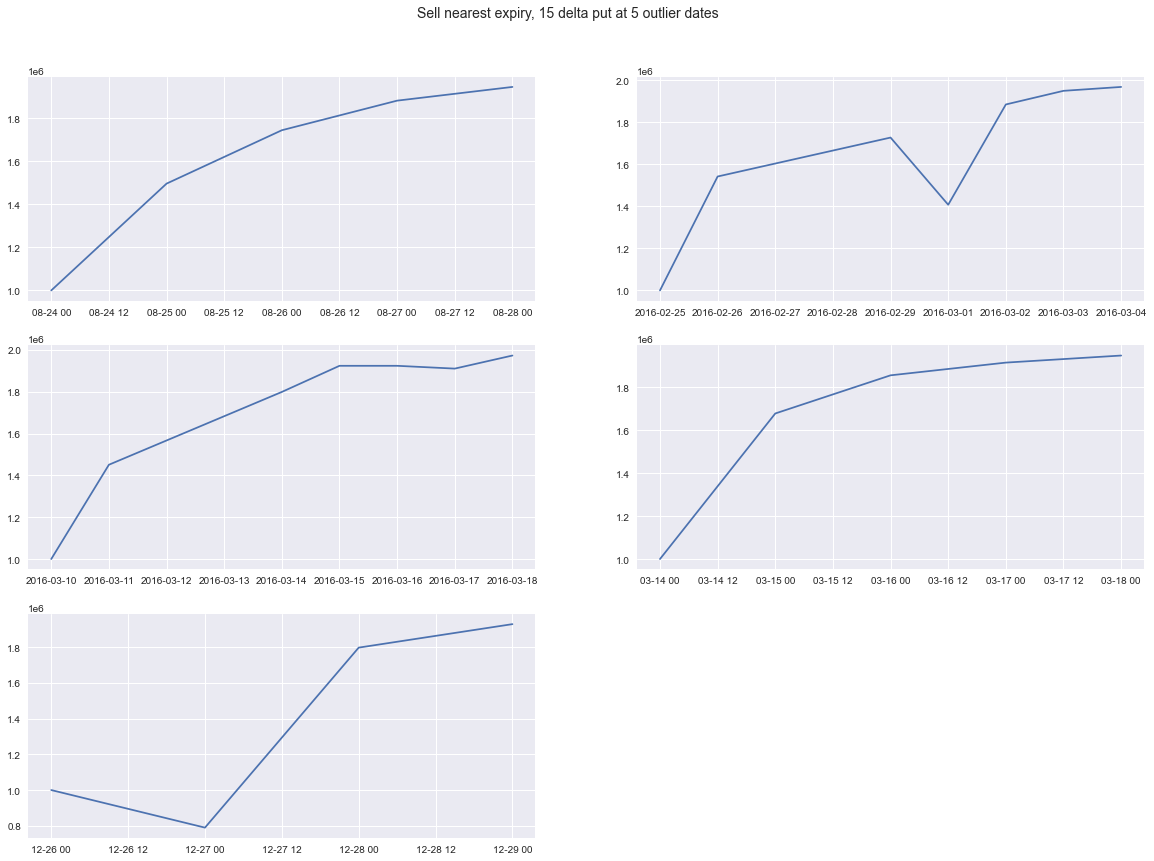

In [147]:
fig = plt.figure(figsize=(20,14)) 
fig.suptitle("Sell nearest expiry, 15 delta put at 5 outlier dates", fontsize=14,y=0.95)

for i in range(len(legs)):
    ax = fig.add_subplot(3, 2, i+1)
    ax.plot(value[i])

In [146]:
[-log['totals']['cost'].sum()*100 for log in logs]

[946308.7248322149,
 967592.5925925927,
 973214.2857142859,
 947368.4210526315,
 929824.5614035088]

# TSLA 2020-2021 outlier dates

In [148]:
start = '2020-01-01'
end = '2021-05-31'
splitdate = '2020-08-31'
splitratio = 5
optiondata = quotedate_contract(full_optiondata, start, end, splitdate, splitratio)

In [149]:
outlier_dates = pd.to_datetime(['2020-12-16', '2021-03-09', '2021-03-26', '2021-03-31', '2021-05-12'])
legs = naked_put(optiondata,outlier_dates)
legs

,underlying,underlying_last,optionroot,type,expiration,quotedate,strike,last,bid,ask,volume,openinterest,impliedvol,delta,gamma,theta,vega,dte
0,TSLA,622.51,TSLA241220P0505,put,2020-12-24,2020-12-16,505.0,5.20,5.10,5.30,285,578,1.16025,-0.107250,0.001634,-1.303953,0.171139,8
1,TSLA,666.79,TSLA120321P0590,put,2021-03-12,2021-03-09,590.0,3.63,3.55,3.70,8690,1941,1.12541,-0.116658,0.002754,-2.292514,0.117673,3
2,TSLA,612.70,TSLA010421P0530,put,2021-04-01,2021-03-26,530.0,3.43,3.40,3.50,1552,1025,0.91319,-0.103347,0.002432,-1.127158,0.150729,6
3,TSLA,668.49,TSLA090421P0580,put,2021-04-09,2021-03-31,580.0,3.54,3.50,3.60,1008,861,0.72170,-0.102480,0.002278,-0.781244,0.179362,9
4,TSLA,593.91,TSLA210521P0500,put,2021-05-21,2021-05-12,500.0,5.50,5.35,5.55,4766,13186,0.97467,-0.122330,0.002153,-1.067050,0.197088,9


In [150]:
options_data = HistoricalOptionsData(optiondata)
options_schema = options_data.schema

In [151]:
data_end_date = optiondata.iloc[-1]['quotedate']
logs = []
inventory = []
pnl = []
value = []
for i, date in enumerate(outlier_dates):
    option_strategy = Strategy(options_schema)

    leg1 = StrategyLeg('leg1', options_schema, option_type=Type.PUT, direction=Direction.SELL)
    leg1.entry_filter = ((options_schema.contract == legs.loc[i,'optionroot']) &
                        (options_schema.dte == legs.loc[i,'dte'])) 
    leg1.exit_filter = options_schema.dte == max((legs.loc[i,'expiration'] - data_end_date).days,0)
 

    option_strategy.add_legs([leg1])

    bt = backtest(initial_capital=1_000_000, transaction_fee=0.5)
    bt.options_strategy = option_strategy
    bt.options_data = options_data
    bt.open_close_type = ('mid', 'mid')
    notional = 1e6
    bt.options_qty = [notional/legs.loc[i,'ask']/100]

    trade_log, options_inventory, portfolio_pnl = bt.run()
    portfolio_value = bt.portfolio_value()
    logs.append(trade_log)
    inventory.append(options_inventory)
    pnl.append(portfolio_pnl)
    value.append(portfolio_value)
    print(f'{i} finished')

0 finished
1 finished
2 finished
3 finished
4 finished


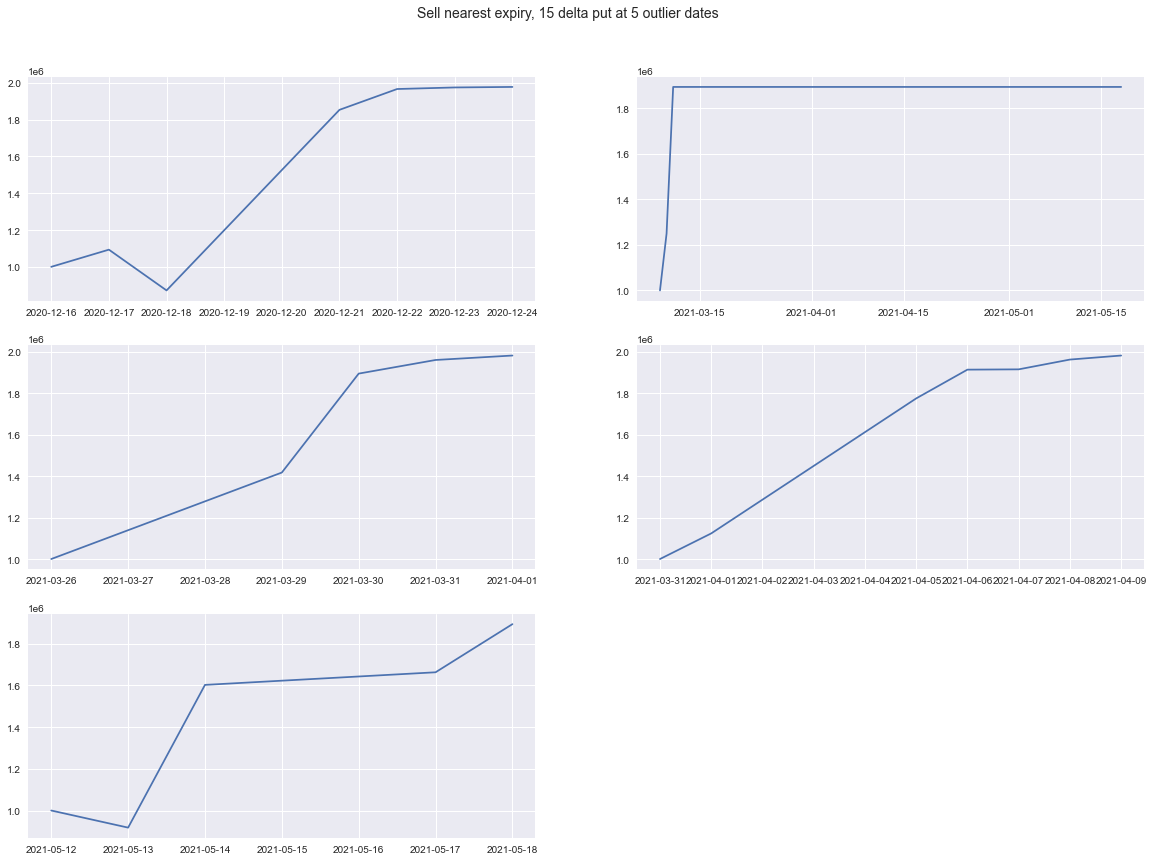

In [152]:
fig = plt.figure(figsize=(20,14)) 
fig.suptitle("Sell nearest expiry, 15 delta put at 5 outlier dates", fontsize=14,y=0.95)

for i in range(len(legs)):
    ax = fig.add_subplot(3, 2, i+1)
    ax.plot(value[i])

# TSLA 2015-2018 outlier dates

In [157]:
start = '2015-01-01'
end = '2019-02-1'
splitdate = '2020-08-31'
splitratio = 5
optiondata = quotedate_contract(full_optiondata, start, end, splitdate, splitratio)

In [158]:
outlier_dates = pd.to_datetime(['2016-02-10', '2016-02-25', '2016-03-10', '2016-03-14',
               '2016-05-05', '2016-06-28', '2016-10-17', '2017-10-10',
               '2017-11-02', '2017-12-26', '2017-12-29', '2018-01-16',
               '2018-03-27', '2018-08-17', '2018-08-30'])
legs = naked_put(optiondata,outlier_dates)
legs

,underlying,underlying_last,optionroot,type,expiration,quotedate,strike,last,bid,ask,volume,openinterest,impliedvol,delta,gamma,theta,vega,dte
0,TSLA,28.7980,TSLA190216P0106,put,2016-02-19,2016-02-10,106.0,2.19,1.92,2.69,155,3,1.75391,-0.103374,0.004664,-0.370263,0.039667,9
1,TSLA,37.4040,TSLA040316P0167,put,2016-03-04,2016-02-25,167.5,0.99,1.04,1.08,425,86,0.63836,-0.104488,0.011576,-0.163342,0.051492,8
2,TSLA,40.9226,TSLA180316P0182,put,2016-03-18,2016-03-10,182.5,1.07,1.10,1.12,1415,663,0.64924,-0.103072,0.009993,-0.187056,0.052192,8
3,TSLA,42.9860,TSLA180316P0197,put,2016-03-18,2016-03-14,197.5,0.82,0.72,0.76,2435,602,0.64067,-0.105691,0.012693,-0.303742,0.039741,4
4,TSLA,42.2410,TSLA130516P0190,put,2016-05-13,2016-05-05,190.0,1.04,0.79,0.80,18080,1757,0.55977,-0.109307,0.009974,-0.218355,0.061247,8
5,TSLA,40.4100,TSLA010716P0192,put,2016-07-01,2016-06-28,192.5,1.02,0.99,1.05,5455,766,0.53850,-0.126621,0.033561,-0.190039,0.035769,3
6,TSLA,38.9020,TSLA211016P0185,put,2016-10-21,2016-10-17,185.0,0.69,0.62,0.73,8480,2466,0.45147,-0.141048,0.024436,-0.250086,0.045892,4
7,TSLA,71.0880,TSLA131017P0342,put,2017-10-13,2017-10-10,342.5,0.60,0.60,0.63,15760,1477,0.34411,-0.110421,0.017201,-0.370238,0.064854,3
8,TSLA,59.8020,TSLA101117P0275,put,2017-11-10,2017-11-02,275.0,1.04,1.13,1.27,2135,243,0.47961,-0.103266,0.008909,-0.222331,0.077798,8
9,TSLA,63.4900,TSLA291217P0305,put,2017-12-29,2017-12-26,305.0,0.59,0.54,0.57,6705,882,0.36490,-0.112057,0.017868,-0.368136,0.057728,3


In [159]:
options_data = HistoricalOptionsData(optiondata)
options_schema = options_data.schema

In [160]:
data_end_date = optiondata.iloc[-1]['quotedate']
logs = []
inventory = []
pnl = []
value = []
for i, date in enumerate(outlier_dates):
    option_strategy = Strategy(options_schema)

    leg1 = StrategyLeg('leg1', options_schema, option_type=Type.PUT, direction=Direction.SELL)
    leg1.entry_filter = ((options_schema.contract == legs.loc[i,'optionroot']) &
                        (options_schema.dte == legs.loc[i,'dte'])) 
    leg1.exit_filter = options_schema.dte == max((legs.loc[i,'expiration'] - data_end_date).days,0)
 

    option_strategy.add_legs([leg1])

    bt = backtest(initial_capital=1_000_000, transaction_fee=0.5)
    bt.options_strategy = option_strategy
    bt.options_data = options_data
    bt.open_close_type = ('mid', 'mid')
    notional = 1e6
    bt.options_qty = [notional/legs.loc[i,'ask']/100]

    trade_log, options_inventory, portfolio_pnl = bt.run()
    portfolio_value = bt.portfolio_value()
    logs.append(trade_log)
    inventory.append(options_inventory)
    pnl.append(portfolio_pnl)
    value.append(portfolio_value)
    print(f'{i} finished')

0 finished
1 finished
2 finished
3 finished
4 finished
5 finished
6 finished
7 finished
8 finished
9 finished
10 finished
11 finished
12 finished
13 finished
14 finished


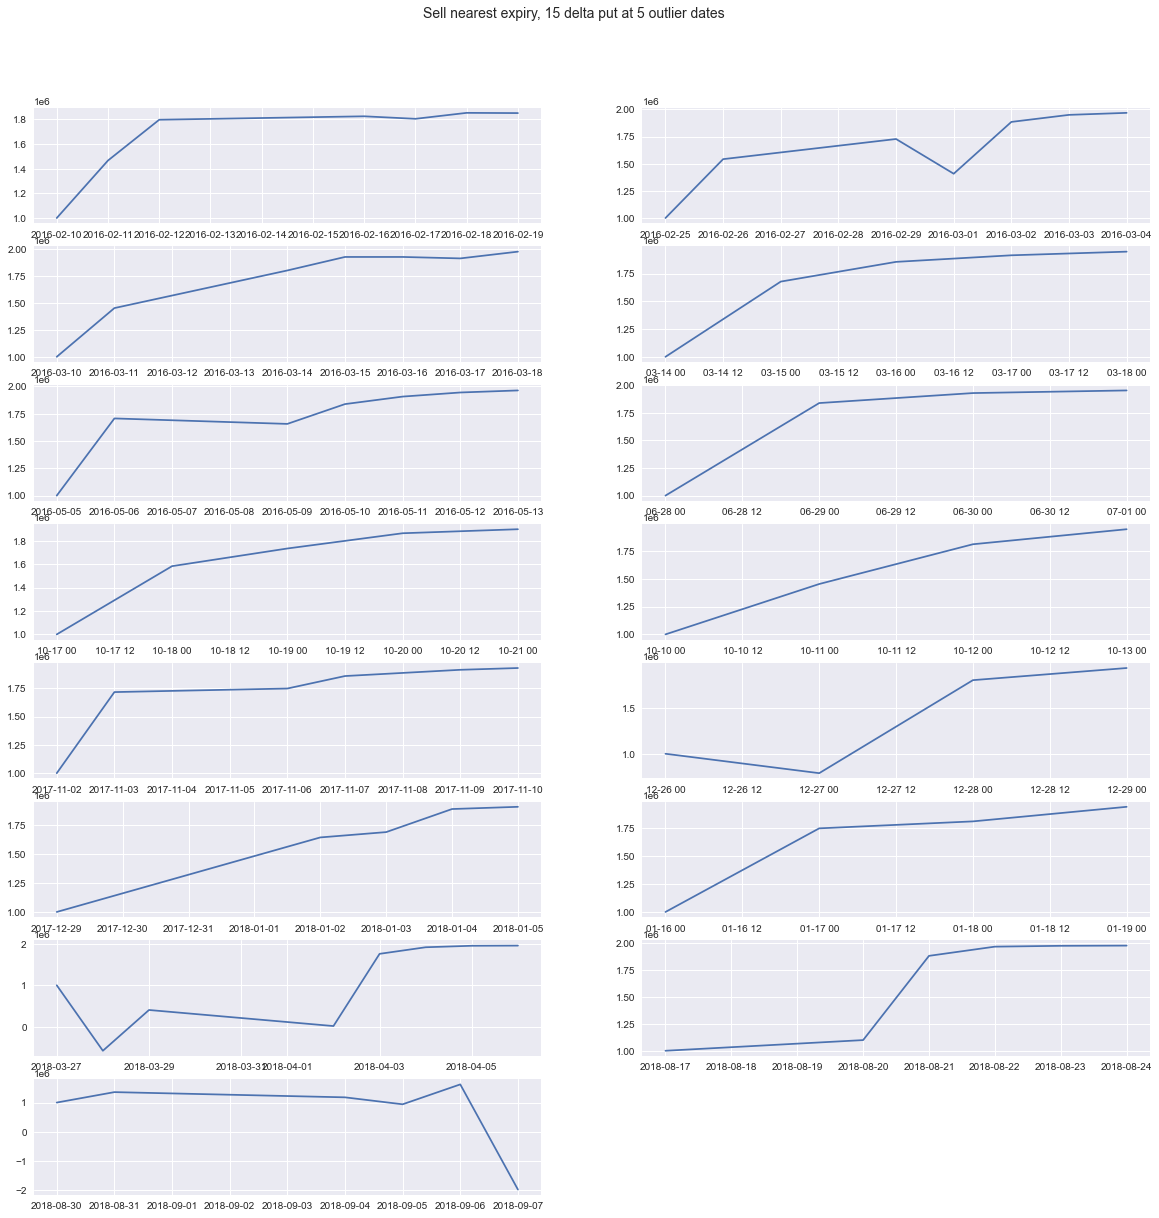

In [163]:
fig = plt.figure(figsize=(20,20)) 
fig.suptitle("Sell nearest expiry, 15 delta put at 5 outlier dates", fontsize=14,y=0.95)

for i in range(len(legs)):
    ax = fig.add_subplot(8, 2, i+1)
    ax.plot(value[i])